# Assignment 2c Notebook: Competitive Co-Evolution of Pac-Man Controllers and Ghost Controllers
For the final assignment in this course, you will use your cumulative understanding and implementation of genetic programming (GP) to implement the competitive co-evolution of Pac-Man controllers and Ghost controllers! From your previous assignment implementations, copy over the following files:
* `base_evolution.py`
* `fitness.py`
* `genetic_programming.py`
* `selection.py`
* `tree_genotype.py`

**If you implemented your parse trees in a separate file, copy that file over as well.** In addition, you will need to import this file in the following code cell.

As usual, be careful not to overwrite any of the other provided files, as we may have modified them between assignments. Make sure you are in the `EC-env` environment. If you are not, terminate the notebook server, run `conda activate EC-env`, and restart the notebook server.

To begin the assignment, execute the following cell.

In [2]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# %pip install snake-eyes-parser

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

import os
import statistics
from scipy import stats
from snake_eyes import read_config
from fitness import *
from tree_genotype import *
from selection import *
from gpac_population_evaluation import *
from genetic_programming import *
from base_evolution import *
from gpac_population_evaluation import competitive_population_evaluation
from search_runner import competitive_genetic_programming_search, run_and_log, split_config
from multiprocessing import Pool
import json

print('The first cell has been executed!')

The first cell has been executed!


## Ghost Controllers
Assuming you already have a working implementation of a GP algorithm for Pac-Man controllers, implementing Ghost controllers should be relatively easy. The only real difference is that, for Ghosts, the `G` terminal returns the distance to the nearest *other* Ghost, and there is an additional `M` terminal returning the distance to Pac-Man (or the nearest Pac-Man, if attempting a deliverable with multiple Pac-Man agents in the game). While the algorithms you used to create, reproduce, and evaluate Pac-Man trees should still be applicable here, you need to make sure your code can cleanly handle the different terminal sets. There are many different ways to accomplish that, and it is up to you to choose how.

## Multi-Population Fitness Evaluation
Competitive fitness in GPac has the quirk of only being relative to encountered opponents. Since opponents belong to populations that are evolving, **you must re-calculate fitness for all individuals at each generation**. Additionally, since it is impractical to play against all opponents, it is also necessary to *approximate* fitness in some way. In practice, you would approximate fitness of an individual through competition with a sample of several opponents. In this assignment, however, we allow for each individual to play against as few as a single opponent per generation to manage computational cost.

As a result of the complex nature of competitive fitness for games like GPac, you will typically perform more fitness evaluations per generation than evolution using the same parameters on a problem with an objective/absolute fitness metric. For this assignment, the first generation will require $SampleSize*max(\mu_{PacMan}, \mu_{Ghost})$ fitness evaluations and each subsequent generation will require $SampleSize*max(\mu_{PacMan}+\lambda_{PacMan}, \mu_{Ghost}+\lambda_{Ghost})$ fitness evaluations, where $SampleSize$ represents the number of opponents sampled to approximate the fitness of each controller. Note that we allow $SampleSize=1$ in this assignment, though this is ill-advised in practice.

**Note**: If the sizes of Pac-Man and Ghost populations are not equal, then some controllers will have to play extra games to complete all fitness evaluations for a generation. If you use a controller more than once, simply calculate fitness as the average of all games the controller played that generation.

In the following cell, implement `competitive_population_evaluation`, a new function that accepts multiple populations as inputs, forms competition match-ups of individuals from the input populations, performs fitness evaluations with the match-ups, and assigns appropriate `fitness` and `base_fitness` members to each individual from the input populations. This should broadly resemble the single-population evaluation functions you implemented in several previous assignments. We've added comments that lay out a recommended approach, but you are free to approach implementing this algorithm however you wish.

**Note**: The `play_GPac` function returns the game score, but Ghost `base_fitness` should be calculated as the negation of game score. Recall also that each GP tree receives a parsimony penalty and you should be mindful to log `base_fitness` instead of `fitness` (which includes this parsimony penalty). Note that you do *not* need to store game logs, unless you wish to for your own purposes, as we will be playing exhibition games after evolution concludes for the purposes of visualization.

In [5]:
from gpac_population_evaluation import competitive_population_evaluation

## Competitive Co-Evolution
Below is a high-level diagram of a 2-population competitive co-evolutionary algorithm. Using your Pac-Man controllers, Ghost controllers, and the `competitive_population_evaluation` function you just implemented, you should have all the necessary components to implement competitive co-evolution!
**Note**: there's a typo in the below figure and both cycles should perform **whole-population** Competitive Fitness Evaluation instead of evaluating only the children.
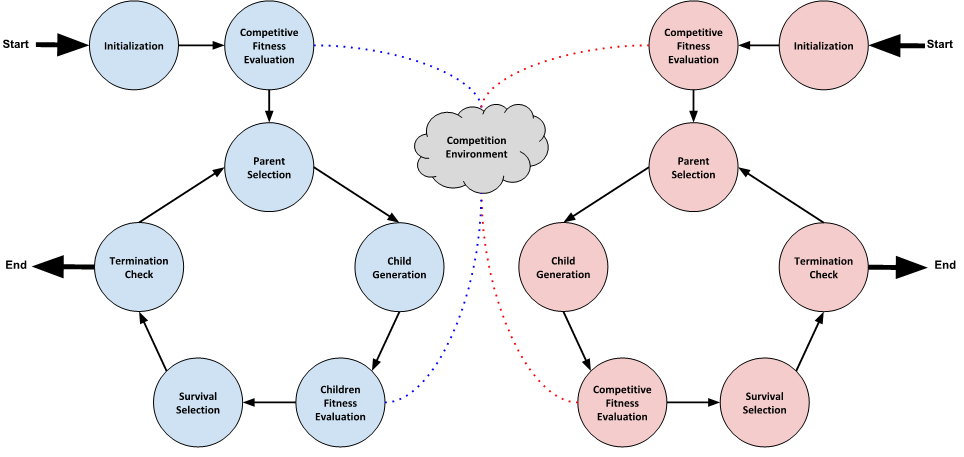

As mentioned previously, the quirks of competitive fitness require that you modify your typical evolution cycles slightly. Namely, you must re-evaluate and recalculate fitness for all individuals each generation. This means that, each generation, each population's children should be added to the adults, and then **all individuals in both populations** should be re-evaluated with your `competitive_population_evaluation` function. Make sure, however, that your `competitive_population_evaluation` function is *not* implemented such that fitness calculations incorporate games played from previous generations (for example, by giving each individual a member variable that stores a list of scores, from which you take an average; you may forget to reset this list each generation, resulting in incorrect fitness calculations).

However, aside from this shared evaluation step, each population should be treated in the code as separate EAs; you should instantiate two different `GeneticProgrammingPopulation` objects. The overall structure of your EA search should be the same as past assignments (there should only be one generational loop), except you need to duplicate all the steps for initialization, child generation, survival, logging, and so on.

### Config Parsing
The config file for co-evolution is a little more complex than previous assignments, so we'll give some code to extract per-species parameters in the following cell. Using the `pac_config` ang `ghost_config` dictonaries returned by this function, you should be able to instantiate GP populations using a similar call signature as previous assignments (e.g., `GeneticProgrammingPopulation(**pac_config['ea'], **pac_config)`)

In [6]:
from search_runner import split_config

## Single Run Experiment
Now that we've covered the quirks of co-evolution a couple times, it's time for you to apply your understanding! In the following cell, implement the code for a single run of your competitive co-evolutionary algorithm.

In [7]:
from search_runner import competitive_genetic_programming_search

In [3]:
# Test your implementation
print(competitive_genetic_programming_search(75, 'configs/2c_green_config.txt'))

{'pac_fitness': 43.41085271317829, 'ghost_fitness': 89.25714285714285, 'fittest_pac': '( ( ( ( ( ( G / 9.257 ) - ( F RAND G ) ) / ( ( 8.242 * F ) + ( W - G ) ) ) / ( ( ( 17.013 + G ) * ( 1.722 RAND -0.406 ) ) * ( ( G * P ) + ( 1.841 / F ) ) ) ) RAND ( ( ( ( 7.974 + F ) * ( 6.019 + G ) ) RAND ( ( G - F ) - ( G + W ) ) ) - ( ( ( W * P ) RAND ( F RAND W ) ) * ( ( G + F ) RAND ( P - -4.303 ) ) ) ) ) + ( ( ( ( ( 16.334 - 10.968 ) - ( W / P ) ) RAND ( ( 6.162 * W ) + ( P / F ) ) ) - ( ( ( P / G ) / ( P * P ) ) - ( ( G RAND P ) / ( P + P ) ) ) ) / ( ( ( ( W + G ) / ( G + F ) ) / ( ( F * F ) * ( G + F ) ) ) + ( ( ( G - P ) RAND ( F RAND F ) ) + ( ( P + G ) / ( F * P ) ) ) ) ) )', 'fittest_ghost': '( ( ( ( ( G / M ) * ( F / M ) ) - ( ( P - F ) * ( W - P ) ) ) / ( ( ( F * W ) RAND ( G - W ) ) + ( ( W * W ) / ( 5.993 * 7.178 ) ) ) ) RAND ( ( ( ( F - F ) + ( G - M ) ) - ( ( 8.097 * 16.331 ) + ( W + W ) ) ) / ( ( ( W - M ) RAND ( 9.599 - -1.903 ) ) - ( ( F * M ) / ( F - W ) ) ) ) )', 'pac_log': ['m

## Tuning
You may use the following cell to tune your parameters. While there are no explicit performance requirements for this assignment (partially because performance in competitive co-evolution is difficult to quantify), we remind you that the default config file contains parameters that are deliberately poor or nonsensical, and you will be penalized if your experiment was conducted without changing these parameters to more sensible values. You are required to utilize configurations that demonstrate a thorough understanding of the parameters' impacts.

In [2]:
number_runs = 5
number_evaluations = 5000
config_filename = 'configs/2c_green_config.txt'
log_directory = 'data/2c/green/logs/tuning/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    run_and_log(competitive_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [6]:
log_directory = 'data/2c/green/logs/tuning/'

pac_gp_logs = []
pac_best_fitness = []
pac_best_genes = []

ghost_gp_logs = []
ghost_best_fitness = []
ghost_best_genes = []

for file in sorted(os.listdir(log_directory)):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        pac_best_fitness.append(data['pac_fitness'])
        pac_gp_logs.append(data['pac_log'])
        pac_best_genes.append(data['fittest_pac'])
        ghost_best_fitness.append(data['ghost_fitness'])
        ghost_gp_logs.append(data['ghost_log'])
        ghost_best_genes.append(data['fittest_ghost'])

best_run = pac_best_fitness.index(max(pac_best_fitness))
print("Best PacMan run was", best_run, "with PacMan score",max(pac_best_fitness), 'and ghost score', ghost_best_fitness[best_run])
print("PacMan Genes:", pac_best_genes[best_run])
print("Ghost Genes:", ghost_best_genes[best_run])

Best PacMan run was 2 with PacMan score 106.08527131782947 and ghost score 96.97142857142858
PacMan Genes: ( ( G / P ) * ( G RAND ( ( W / ( W * F ) ) / 12.763 ) ) )
Ghost Genes: ( W - M )


## Multi-Run Experiment
Implement a full 10-run experiment with 5,000 fitness evaluations per run. In the final generation of each run, log the parse tree and game log of the individual with the best base fitness *for each population*. For the run that produced the highest base Pac-Man fitness in the final generation, play an exhibition game between the highest-base-fitness Pac-Man controller and highest-base-fitness Ghost controller from that run's final generation. Save the log from this exhibition game and visualize it for informal analysis in your report. For more detail on report requirements, see the assignment description.

**Note**: Make sure you keep the best Pac-Man controller and the best Ghost controller from the end of each run *in memory*, in addition to logging the parse tree's string representation. You will use them after your experiment is complete for post-hoc analysis.

In [2]:
number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2c_green_config.txt'
log_directory = 'data/2c/green/logs/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    run_and_log(competitive_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [13]:
log_directory = 'data/2c/green/logs/'

pac_gp_logs = []
pac_best_fitness = []
pac_best_genes = []

ghost_gp_logs = []
ghost_best_fitness = []
ghost_best_genes = []

for file in sorted(os.listdir(log_directory)):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        pac_best_fitness.append(data['pac_fitness'])
        pac_gp_logs.append(data['pac_log'])
        pac_best_genes.append(data['fittest_pac'])
        ghost_best_fitness.append(data['ghost_fitness'])
        ghost_gp_logs.append(data['ghost_log'])
        ghost_best_genes.append(data['fittest_ghost'])

print("All genes, by run:")
for i, (p,g) in enumerate(zip(pac_best_genes, ghost_best_genes)):
    print(f"{str(i) + ' pac' :<10} {p}\n{str(i)+' ghost':<10} {g}")

best_run = pac_best_fitness.index(max(pac_best_fitness))
print("Best PacMan run was", best_run, "with PacMan score",max(pac_best_fitness), 'and ghost score', ghost_best_fitness[best_run])
exhibition_pac_genes = pac_best_genes[best_run]
exhibition_ghost_genes = ghost_best_genes[best_run]

All genes, by run:
0 pac      ( ( F - F ) - ( F / G ) )
0 ghost    ( ( ( M * P ) * ( W / 3.186 ) ) - ( ( M * F ) * 13.559 ) )
1 pac      ( ( F / ( P RAND 11.991 ) ) * ( ( ( P / G ) - P ) + ( G * 12.771 ) ) )
1 ghost    ( ( F + P ) / M )
2 pac      ( ( 15.782 RAND ( ( F - P ) - P ) ) * G )
2 ghost    ( ( M / F ) * ( M / ( M / ( P - F ) ) ) )
3 pac      ( ( F * ( G - 1.739 ) ) - F )
3 ghost    ( ( ( G / M ) / ( 1.515 RAND M ) ) - ( M - P ) )
4 pac      ( ( 12.905 RAND ( ( P + G ) + G ) ) * G )
4 ghost    ( ( ( P / P ) / M ) - M )
5 pac      ( ( ( W / 19.425 ) RAND G ) + G )
5 ghost    ( ( ( P / ( F + ( F * P ) ) ) * P ) - M )
6 pac      ( G / ( 6.827 + ( P + P ) ) )
6 ghost    ( P - ( F * ( M + ( F / F ) ) ) )
7 pac      ( ( ( ( ( 1.860 RAND G ) / ( P * 8.025 ) ) * G ) * ( P + G ) ) * 1.860 )
7 ghost    ( ( P RAND ( ( ( ( ( W / W ) * F ) / ( ( F + P ) + ( G - M ) ) ) / F ) / G ) ) - M )
8 pac      ( ( ( ( F * G ) - F ) * F ) * ( ( ( 7.267 RAND G ) / ( P * F ) ) / ( ( F - -3.642 ) / F ) )

In [4]:
config_filename = 'configs/2c_green_config.txt'
log_directory = 'data/2c/green/logs/'

config = read_config(config_filename, globals(), locals())
pac_config, ghost_config = split_config(config)

exhibition_pac = TreeGenotype()
exhibition_pac.genes = ParseTree.from_string(exhibition_pac_genes, **pac_config['problem'])
exhibition_ghost = TreeGenotype()
exhibition_ghost.genes = ParseTree.from_string(exhibition_ghost_genes, **ghost_config['problem'])

score, log = play_GPac(exhibition_pac, exhibition_ghost, **config['game'])

with open(log_directory + 'exhibition_log_game.txt', 'w') as f:
    [f.write(s+'\n') for s in log]

print(exhibition_pac.genes)
print(exhibition_ghost.genes)

( ( ( ( ( 1.860 RAND G ) / ( P * 8.025 ) ) * G ) * ( P + G ) ) * 1.860 )
( ( P RAND ( ( ( ( ( W / W ) * F ) / ( ( F + P ) + ( G - M ) ) ) / F ) / G ) ) - M )


In [14]:
!head data/2c/green/logs/exhibition_log_game.txt

35
20
m 0 19
0 34 0
1 0 0
2 34 19
w 0 9
w 0 10
w 1 1
w 1 2


## Report
Now you should have the data required to complete the report described in the assignment document. There are components of the report you need to complete independently, but this notebook will walk you through post-hoc analysis and plotting.

### Performance Analysis
Competitive coevolution with GPac is novel compared to previous assignments, as we are without an absolute fitness metric and are only able to approximate fitness using relative performance metrics. For one, this means that performance metrics between two agents must be generated against the same set of opponents for comparisons of those metrics to be valid. This is permissible (to an extent) during evolution, but must be explicitly considered during meaningfully rigorous performance analysis. 

As an additional point of complication, there may exist intransitivity between different controllers. For example, it may be the case that Pac-Man controller $A$ outperforms Pac-Man controller $B$ against Ghost controller $X$, but $B$ outperforms $A$ against Ghost controller $Y$. In these cases, selecting the *best* controller relies on accepting performance trade-offs between controllers in a manner not unlike a multi-objective problem. As a consequence of this characteristic, even using aggregate metrics like mean performance may be a dubious decision in competitive games with intransitivity.

Given the existence of relative performance metrics and intransitivity in a problem, with the intractability of assessing performance against all possible opponents, measuring performance in competitive games at all is an open and underexplored area of research! Fortunately, we have recommendations for analysis techniques based on contemporary research related to this very topic.

The approach required for the GREEN report deliverable is inspired by the 2013 publication *Improving Coevolution by Random Sampling* [1]. In this technique, you will take the highest-fitness controller of each species at the last generation of co-evolution and have them compete against a reference population of randomly-generated opponents. In other words, your 10 Pac-Man controllers will play against all opponents in a population of 100 randomly-generated Ghost controllers. Similarly, your 10 Ghost controllers will play against all opponents in a population of 100 randomly-generated Pac-Man controllers. It's worth noting that our method is lacking in rigor compared to [1], but will be sufficient for this assignment. See the appendix of this notebook for information about the shortcomings of our method.

In the following cell, load your best controllers from each run into the required variables. Then execute the cell to produce a box plot for each run showing the distribution of performance of each controller against the 100 random opponents.

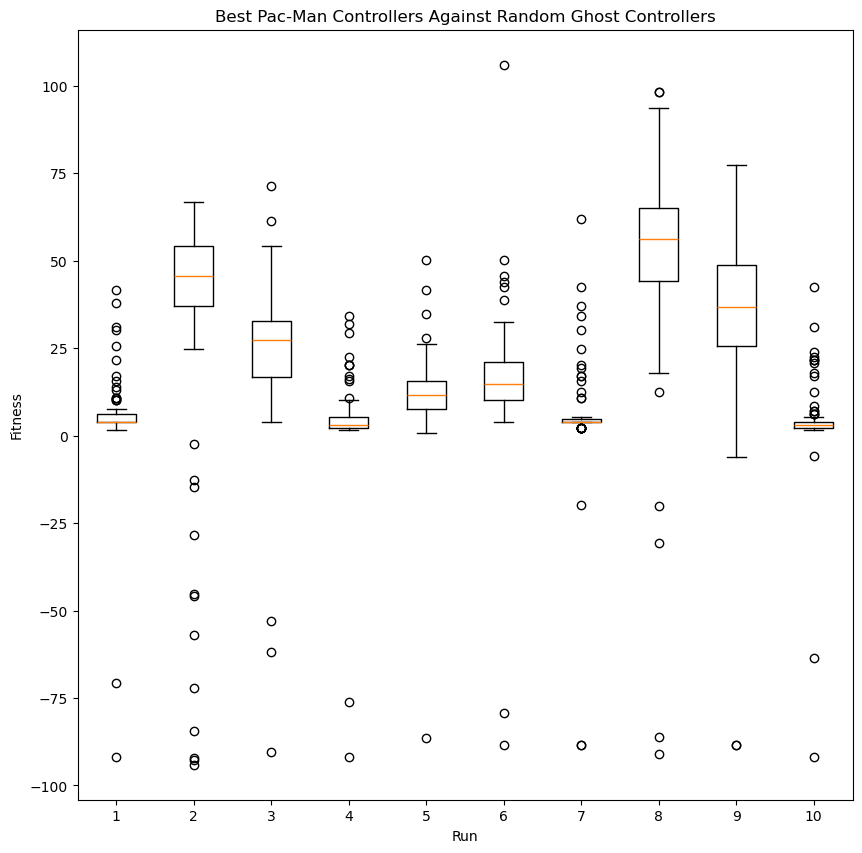

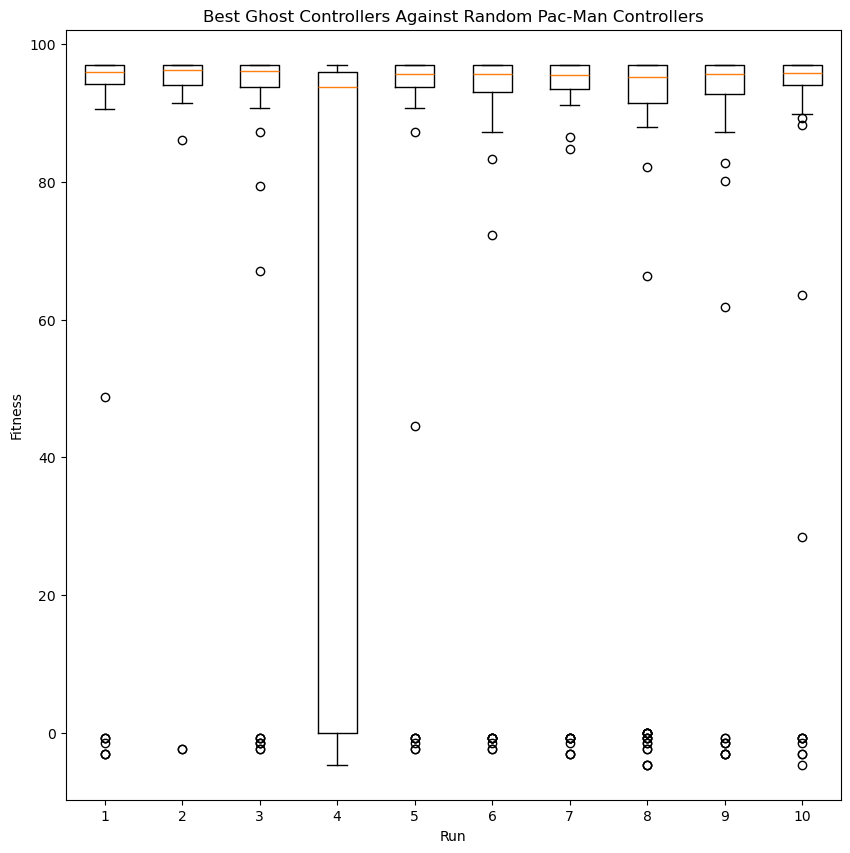

In [6]:
config = read_config('configs/2c_green_config.txt', globals(), locals())
pac_config, ghost_config = split_config(config)

# Assign your best Pac-Man controllers to this variable
# It should be a list of 10 controllers, each being the
# best Pac-Man from the last generation of one of the runs
best_pacs = []
for i in pac_best_genes:
    g = TreeGenotype()
    g.genes = ParseTree.from_string(i, **pac_config['problem'])
    best_pacs.append(g)

best_ghosts = []
for i in ghost_best_genes:
    g = TreeGenotype()
    g.genes = ParseTree.from_string(i, **ghost_config['problem'])
    best_ghosts.append(g)

random_ghosts = TreeGenotype.initialization(100, **ghost_config['problem'])
pac_scores = []
for pac in best_pacs:
    pac_scores.append([])
    for ghost in random_ghosts:
        # Note you may need to change this line, depending on how your
        # play_GPac implementation expects the controllers to be passed in.
        score, _ = play_GPac(pac, ghost, **config['game'])
        pac_scores[-1].append(score)
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(pac_scores)
ax.set(title='Best Pac-Man Controllers Against Random Ghost Controllers', xlabel='Run', ylabel='Fitness')
plt.show()

random_pacs = TreeGenotype.initialization(100, **pac_config['problem'])
ghost_scores = []
for ghost in best_ghosts:
    ghost_scores.append([])
    for pac in random_pacs:
        # Note you may need to change this line, depending on how your
        # play_GPac implementation expects the controllers to be passed in.
        score, _ = play_GPac(pac, ghost, **config['game'])
        ghost_scores[-1].append(-1 * score)
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(ghost_scores)
ax.set(title='Best Ghost Controllers Against Random Pac-Man Controllers', xlabel='Run', ylabel='Fitness')
plt.show()

# YELLOW Deliverable
Now that you've completed the GREEN deliverable and performed analysis against a reference set of randomly-generated opponents, experiment with another performance analysis technique. A potential shortcoming of the analysis method used in the GREEN deliverable is that the randomly-generated opponents don't represent the space of performant controllers very well. While performance against poor-performing agents may still be meaningful, it may not be very interesting if our focus is performing well against performant opponents (something addressed by the full analysis technique used in [1]). The 2009 publication *Why Coevolution Doesn't "Work": Superiority and Progress in Coevolution* [2] points out that many competitive coevolution studies suffer from analysis techniques that fail to separate a test set of opponents (those seen during co-evolution) from an evaluation set of opponents (not necessarily seen during co-evolution). 

As a means of circumventing playing against known "test set" opponents while evaluating against opponents found using co-evolution, split the controllers found in your runs in half and have them compete against each other. Specifically, have the Pac-Man controllers from the first 5 runs play the Ghost controllers from the last 5 runs, while the Pac-Man controllers from the last 5 runs should play the Ghost controllers from the first 5 runs. Each pair of controllers should play against each other 10 times, to get a better sample of their performance, and their final score in that pairing should be taken as the average score of these 10 games.

Store the scores as a 10x10 matrix, where `scores[i][j]` is the average score of run `i`'s Pac-Man controller against run `j`'s Ghost controller. Calculate the scores as Pac-Man's score (i.e., do *not* negate values for the Ghost controllers or apply a parsimony penalty). The half of these entries that will not be played (such as `scores[2][4]` or `scores[8][6]`) should be set to `None`.

In the following cell, conduct the pairing & score calculation as described above. When that's done, continue reading below the cell.

In [3]:
config_filename = 'configs/2c_green_config.txt'
log_directory = 'data/2c/green/logs/'

config = read_config(config_filename, globals(), locals())
pac_config, ghost_config = split_config(config)

pac_best_genes = []
ghost_best_genes = []

for file in sorted(os.listdir(log_directory)):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        pac_best_genes.append(data['fittest_pac'])
        ghost_best_genes.append(data['fittest_ghost'])

best_pacs = []
for g in pac_best_genes:
    t = TreeGenotype()
    t.genes = ParseTree.from_string(g, **pac_config['problem'])
    best_pacs.append(t)

best_ghosts = []
for g in ghost_best_genes:
    t = TreeGenotype()
    t.genes = ParseTree.from_string(g, **ghost_config['problem'])
    best_ghosts.append(t)

print(len(best_pacs), len(best_ghosts))


10 10


In [6]:
from tqdm import tqdm
config = read_config(config_filename, globals(), locals())
pac_config, ghost_config = split_config(config)

scores = [[None]*10 for _ in range(10)]

## First Half
for i in tqdm(range(5)):
    for j in range(5,10):
        p = best_pacs[i]
        g = best_ghosts[j]
        scores[i][j] = 0
        for _ in range(10):
            score, _ = play_GPac(p, g, **config['game'])
            scores[i][j] += score
## Second Half
for i in tqdm(range(5, 10)):
    for j in range(5):
        p = best_pacs[i]
        g = best_ghosts[j]
        scores[i][j] = 0
        for _ in range(10):
            score, _ = play_GPac(p, g, **config['game'])
            scores[i][j] += score

for i in range(10):
    for j in range(10):
        if scores[i][j] is not None:
            scores[i][j] /= 10

print(*scores, sep='\n')

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:06<00:00,  1.30s/it]

[None, None, None, None, None, -92.26312292358806, -92.26312292358806, -92.73794019933555, -89.79844961240312, -92.26312292358806]
[None, None, None, None, None, -94.44456256921373, -94.58569213732004, -89.86290143964564, -90.9930454042082, -94.53102990033221]
[None, None, None, None, None, -94.66795127353267, -93.95065337763012, -75.2982945736434, -91.00996677740864, -93.83065337763011]
[None, None, None, None, None, -92.26312292358806, -92.26312292358806, -93.44305647840532, -89.79844961240312, -92.26312292358806]
[None, None, None, None, None, -93.46516057585825, -89.75295681063123, -68.66392026578072, -41.279424141749715, -92.00349944629014]
[-45.870431893687716, -93.39583610188262, -87.14768549280177, -92.1324473975637, -91.55229235880398, None, None, None, None, None]
[-86.2330011074197, -26.012403100775202, -6.737098560354383, -69.45439645625692, -88.35481727574752, None, None, None, None, None]
[-85.59623477297896, -89.13475083056478, -56.02617940199335, -74.1744407530454, -88.

Now, load the scores you've calculated into the `scores` variable in the next cell. Then, execute the cell to get a visualization of your data. Make sure to read the paragraph below the next code cell; that's also part of this YELLOW deliverable! This cell contains some test code that will generate random values, so you can know what kind of output to expect.

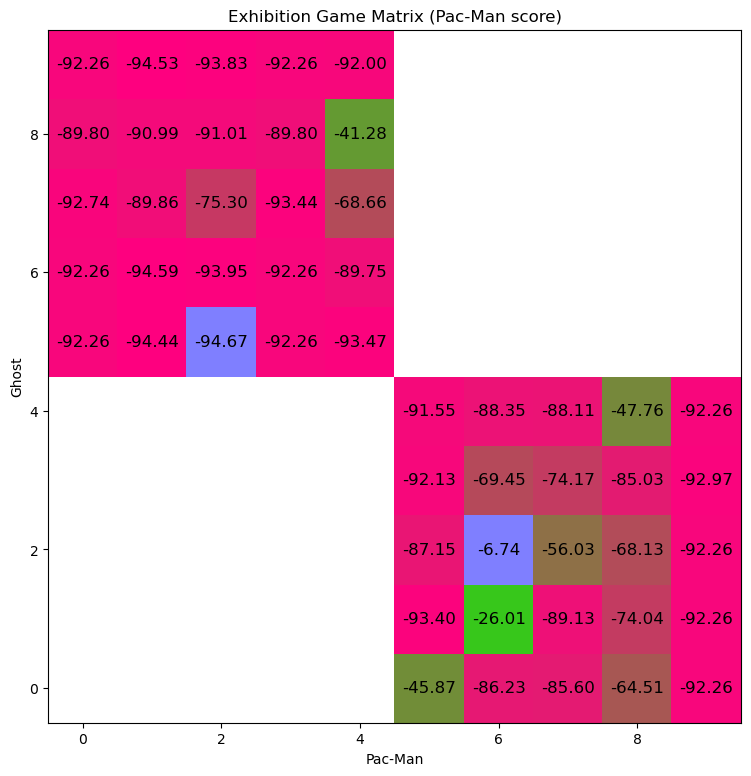

In [7]:
from math import inf
import random

# Load your score matrix here
scores = scores

####################
#    TEST CODE     #
####################
# scores = [[None for y in range(10)] for x in range(10)]
# for x in range(10):
#     for y in range(10):
#         if (x < 5 and y >= 5) or (x >= 5 and y < 5):
#             scores[x][y] = random.uniform(-100, 100)
#         else:
#             scores[x][y] = None
####################
# END OF TEST CODE #
####################

rgbs = [[[] for y in range(len(scores[x]))] for x in range(len(scores))]
text = [[None for y in range(len(scores[x]))] for x in range(len(scores))]
max_score = -inf
min_score = inf
for x in range(len(scores)):
    for y in range(len(scores[x])):
        # Deliberately inverted; imshow is weird, rasters are column-major
        score = scores[y][x]
        if score is not None:
            if max_score < score:
                max_score = score
                max_score_loc = (x, y)
            if min_score > score:
                min_score = score
                min_score_loc = (x, y)
                
    
for x in range(len(scores)):
    for y in range(len(scores[x])):
        # Deliberately inverted; imshow is weird, rasters are column-major
        score = scores[y][x]
        if score is None:
            rgbs[x][y] = [1.0, 1.0, 1.0]
        else:
            # Scale the scores from [min_score, max_score] to [0, 1] for coloring
            scalar = (score - min_score) / (max_score - min_score)
            # This is hopefully still legible for people with deuteranopia
            # Feel free to modify the RGB calculations if you want
            rgbs[x][y] = [1 - scalar, scalar, (1 - scalar) / 2]
            text[x][y] = f'{score:.2f}'

# Highlight the min and max scores with a unique color
rgbs[max_score_loc[0]][max_score_loc[1]] = [0.5, 0.5, 1.0]
rgbs[min_score_loc[0]][min_score_loc[1]] = [0.5, 0.5, 1.0]

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(rgbs, origin='lower')
for x in range(len(text)):
    for y in range(len(text[x])):
        if not text is None:
            ax.text(y, x, text[x][y], ha='center', va='center', fontsize='large')
ax.set(title='Exhibition Game Matrix (Pac-Man score)', xlabel='Pac-Man', ylabel='Ghost')
plt.show()

Are you able to see any signs of intransitivity in this visualization? Do the results differ meaningfully from those obtained using the GREEN analysis method? Place the visualization and the answers to these prompts in your report. For information about the shortcomings of this approach, see the appendix of this notebook.

# RED Deliverables
Feel free to create more notebook cells for RED deliverables as necessary. Here are some comments on those deliverables.

### Config Files
For the RED deliverables in this assignment, you are tasked with creating your own config files. For many of the RED deliverables, you can use the provided config files and code as inspiration for new config files and the parsing of those files, respectively.

### Modified Fitness Function
The RED deliverables require a modified version of the `play_GPac` function. See the last cell of `2b_notebook.ipynb` for more information.

## References
[1] Wojciech Jaśkowski, Paweł Liskowski, Marcin Szubert, and Krzysztof Krawiec. 2013. Improving coevolution by random sampling. In Proceedings of the 15th annual conference on Genetic and evolutionary computation (GECCO '13). Association for Computing Machinery, New York, NY, USA, 1141–1148. https://doi.org/10.1145/2463372.2463512

[2] Thomas Miconi. 2009. Why Coevolution Doesn't "Work": Superiority and Progress in Coevolution. In Proceedings of the 12th European Conference on Genetic Programming (EuroGP '09). Springer-Verlag, Berlin, Heidelberg, 49–60. https://doi.org/10.1007/978-3-642-01181-8_5

## Appendix

### GREEN Analysis Method Shortcomings
As mentioned previously in the notebook, our analysis method in GREEN is lacking rigor compared to the methods used in [1]. In [1], the methodology employed uses much larger populations of randomly-generated opponents that play against a still larger population of random opponents and are sorted based on performance. This seemingly worked well in [1] because the strategy representation is essentially a linear sequence of actions. For more complicated controllers with stochasticity (e.g., the `RAND` primitive), the idea of playing against randomly generated opponents at all has meaningful issues. First, random search has no guarantee of exploring performant strategy space. In other words, the agents you want to assess may only play against poor-performing and uninteresting opponents (compared to performant strategies discovered through other optimization approaches). Second, a single game between two given controllers may not be representative of the performance of either controller against one another. Depending on the amount of stochasticity in the controllers and the problem itself, it may take an intractable number of games to determine an accurate mean score for all pairs of agents used in analysis. As such, this method was not originally intended for use on competitions with stochasticity. Third, the representative strategy was selected as the highest-fitness individual from each population at the last generation of co-evolution and that fitness may have been approximated through competition with as few as one opponent. As a result, there's a very good chance the representative agent of each run is not the best agent discovered throughout the entire run, but rather an agent that was just paired against a poorly-performing agent in the final generation. Solving these issues requires being able to meaningfully assess global performance against all possible strategies [2], which is an open area of research.

### YELLOW Analysis Method Shortcomings
As was the case with the GREEN analysis method, the YELLOW analysis method also suffers from issues pertaining to stochasticity during competition between two strategies and difficulties in selecting the strategy found during each run that has the best global performance against all possible opponents [2]. The latter issue (using representatives that may not have the best global performance in the run) is somewhat exacerbated in this technique, since the primary improvement over the GREEN analysis method is competition against performant opponents. Additionally, since such few opponents are being used, issues with intransitivity can arise. Namely, if a strategy is well-suited for competition against a particular type of high-performing strategy that happens to not be well-represented in the evaluation set of opponents, then the performance of that strategy may appear deceptively low.